Naive Bayes Performance:
Accuracy: 0.94
Precision: 0.86
Recall: 0.93

Active Learning Performance:
Accuracy: 0.93
Precision: 0.85
Recall: 0.93

Results saved to 'model_performance.csv'.
Learning curve saved as 'active_learning_curve.png'.


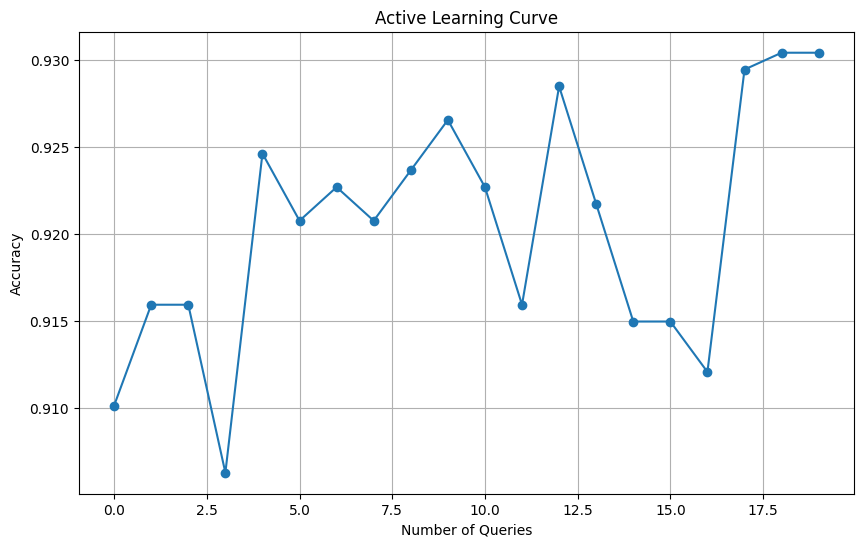

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('D:\\Active Learning\\Final AL\\seminar\\spam.csv', encoding='latin-1')

# Select relevant columns
data = data[['text', 'label']]
data['label'] = data['label'].map({'spam': 1, 'ham': 0})

# Preprocess data
data = data.dropna()
vectorizer = TfidfVectorizer(stop_words='english', max_features=3000)
X = vectorizer.fit_transform(data['text']).toarray()
y = data['label'].values

# Split data: 80% train+pool, 20% test
X_train_pool, X_test, y_train_pool, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initial labeled set (5%) and unlabeled pool
n_initial = max(2, int(0.05 * len(X_train_pool)))  # At least 2 samples
initial_idx = np.random.choice(range(len(X_train_pool)), size=n_initial, replace=False)
X_labeled = X_train_pool[initial_idx]
y_labeled = y_train_pool[initial_idx]
pool_idx = np.setdiff1d(range(len(X_train_pool)), initial_idx)
X_pool = X_train_pool[pool_idx]
y_pool = y_train_pool[pool_idx]

# Ensure both classes in y_labeled
if len(np.unique(y_labeled)) < 2:
    print("Warning: y_labeled has only one class, adding one sample of the other class.")
    minority_class = 1 if np.sum(y_labeled) == 0 else 0
    minority_idx = np.where(y_pool == minority_class)[0]
    if len(minority_idx) > 0:
        idx = minority_idx[0]
        X_labeled = np.vstack((X_labeled, X_pool[idx]))
        y_labeled = np.append(y_labeled, y_pool[idx])
        X_pool = np.delete(X_pool, idx, axis=0)
        y_pool = np.delete(y_pool, idx, axis=0)
    else:
        print("No samples of minority class available, stopping active learning.")
        y_pred_al = np.zeros_like(y_test)  # Fallback prediction
        al_accuracy = accuracy_score(y_test, y_pred_al)
        al_precision = precision_score(y_test, y_pred_al, zero_division=0)
        al_recall = recall_score(y_test, y_pred_al, zero_division=0)
        print("\nActive Learning Performance:")
        print(f"Accuracy: {al_accuracy:.2f}")
        print(f"Precision: {al_precision:.2f}")
        print(f"Recall: {al_recall:.2f}")
        results = pd.DataFrame({
            'Model': ['Naive Bayes', 'Active Learning'],
            'Accuracy': [accuracy_score(y_test, nb_classifier.predict(X_test)), al_accuracy],
            'Precision': [precision_score(y_test, nb_classifier.predict(X_test)), al_precision],
            'Recall': [recall_score(y_test, nb_classifier.predict(X_test)), al_recall]
        })
        results.to_csv('model_performance.csv', index=False)
        print("\nResults saved to 'model_performance.csv'.")
        exit()

# Naive Bayes Classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_pool, y_train_pool)
y_pred_nb = nb_classifier.predict(X_test)

# Evaluate Naive Bayes
nb_accuracy = accuracy_score(y_test, y_pred_nb)
nb_precision = precision_score(y_test, y_pred_nb)
nb_recall = recall_score(y_test, y_pred_nb)

print("Naive Bayes Performance:")
print(f"Accuracy: {nb_accuracy:.2f}")
print(f"Precision: {nb_precision:.2f}")
print(f"Recall: {nb_recall:.2f}")

# Active Learning (Manual Uncertainty Sampling)
classifier = RandomForestClassifier(n_estimators=50, random_state=42)
n_queries = min(20, len(X_pool))
accuracies = []

for i in range(n_queries):
    if len(X_pool) < 1:
        print("X_pool is empty, stopping active learning.")
        break
    classifier.fit(X_labeled, y_labeled)
    probas = classifier.predict_proba(X_pool)
    if probas.shape[0] == 0 or probas.ndim != 2 or probas.shape[1] != 2:
        print(f"Warning: Invalid probas shape {probas.shape} at iteration {i}, stopping.")
        break
    uncertainty = np.abs(probas[:, 0] - probas[:, 1])
    query_idx = np.argmin(uncertainty)
    X_labeled = np.vstack((X_labeled, X_pool[query_idx]))
    y_labeled = np.append(y_labeled, y_pool[query_idx])
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx, axis=0)
    y_pred_al = classifier.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred_al))

# Final evaluation of Active Learning
y_pred_al = classifier.predict(X_test)
al_accuracy = accuracy_score(y_test, y_pred_al)
al_precision = precision_score(y_test, y_pred_al, zero_division=0)
al_recall = recall_score(y_test, y_pred_al, zero_division=0)

print("\nActive Learning Performance:")
print(f"Accuracy: {al_accuracy:.2f}")
print(f"Precision: {al_precision:.2f}")
print(f"Recall: {al_recall:.2f}")

# Save results to CSV for Tableau
results = pd.DataFrame({
    'Model': ['Naive Bayes', 'Active Learning'],
    'Accuracy': [nb_accuracy, al_accuracy],
    'Precision': [nb_precision, al_precision],
    'Recall': [nb_recall, al_recall]
})
results.to_csv('model_performance.csv', index=False)
print("\nResults saved to 'model_performance.csv'.")

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(range(len(accuracies)), accuracies, marker='o')
plt.title('Active Learning Curve')
plt.xlabel('Number of Queries')
plt.ylabel('Accuracy')
plt.grid(True)
plt.savefig('active_learning_curve.png')
print("Learning curve saved as 'active_learning_curve.png'.")

In [2]:
import pandas as pd
data = pd.read_csv('D:\Active Learning\Final AL\seminar\spam.csv', encoding='latin-1')
print("Columns:", data.columns.tolist())
print("\nFirst few rows:\n", data.head())

Columns: ['Unnamed: 0', 'label', 'text', 'label_num']

First few rows:
    Unnamed: 0 label                                               text  \
0         605   ham  Subject: enron methanol ; meter # : 988291\r\n...   
1        2349   ham  Subject: hpl nom for january 9 , 2001\r\n( see...   
2        3624   ham  Subject: neon retreat\r\nho ho ho , we ' re ar...   
3        4685  spam  Subject: photoshop , windows , office . cheap ...   
4        2030   ham  Subject: re : indian springs\r\nthis deal is t...   

   label_num  
0          0  
1          0  
2          0  
3          1  
4          0  


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
data = pd.read_csv('D:\\Active Learning\\Final AL\\seminar\\spam.csv', encoding='latin-1')
data = data[['text', 'label']]
data['label'] = data['label'].map({'spam': 1, 'ham': 0})
data = data.dropna()
print("Dataset size:", len(data))
print("Label distribution:\n", data['label'].value_counts())
X_train_pool, X_test, y_train_pool, y_test = train_test_split(
    data['text'], data['label'], test_size=0.2, random_state=42
)
n_initial = int(0.05 * len(X_train_pool))  # 5% as in updated code
print("X_train_pool size:", len(X_train_pool))
print("n_initial (5%):", n_initial)
print("X_pool size (after taking 5%):", len(X_train_pool) - n_initial)
initial_idx = np.random.choice(range(len(X_train_pool)), size=n_initial, replace=False)
y_initial = y_train_pool[initial_idx]
print("y_initial distribution:", np.bincount(y_initial))